In [104]:
%cd maze-dataset
!pip install -r requirements.txt


[WinError 2] 지정된 파일을 찾을 수 없습니다: 'maze-dataset'
c:\Users\sean2\바탕 화면\workspace\mdp\maze-dataset


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [105]:
!pip install jaxtyping

In [106]:
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators

grid_n = 5
cfg = MazeDatasetConfig(
    name="fixed_start_end_example",
    grid_n=grid_n,            # 미로 크기 (5x5)
    n_mazes=4,                # 미로 4개 생성
    maze_ctor=LatticeMazeGenerators.gen_dfs,  # DFS 기반 미로 생성
    maze_ctor_kwargs=dict(do_forks=True),     # fork(분기) 허용 여부
    endpoint_kwargs=dict(
        allowed_start=[(0, 0)],                   # 왼쪽 위 (0,0) 고정
        allowed_end=[(grid_n - 1, grid_n - 1)],   # 오른쪽 아래 (4,4) 고정
        # 필요 시 deadend_start=True 등 옵션도 가능
    ),
)

dataset = MazeDataset.from_config(cfg)

# 실제 미로 하나 확인
m = dataset[0]
print(m.as_ascii(show_endpoints=True))  # ASCII 형태로 시각화


###########
#SXXXX  # #
# ###X# # #
#   #X#   #
#####X#####
#XXXXX#   #
#X### ### #
#X#     # #
#X####### #
#XXXXXXXXE#
###########


c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([0, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([4, 4]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [2, 1],
       [2, 0],
       [3, 0],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(
c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\jso

In [107]:
# visual representation as ascii art
print(m.as_ascii())

###########
#SXXXX  # #
# ###X# # #
#   #X#   #
#####X#####
#XXXXX#   #
#X### ### #
#X#     # #
#X####### #
#XXXXXXXXE#
###########


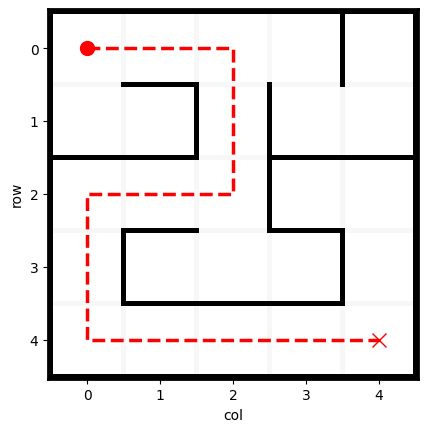

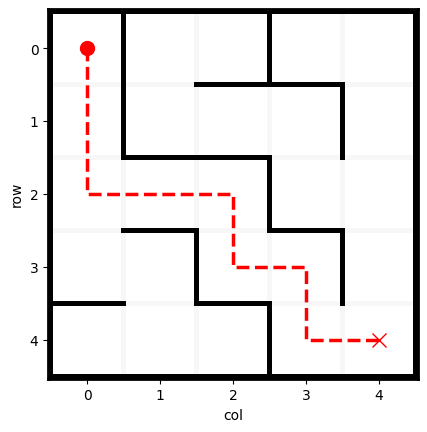

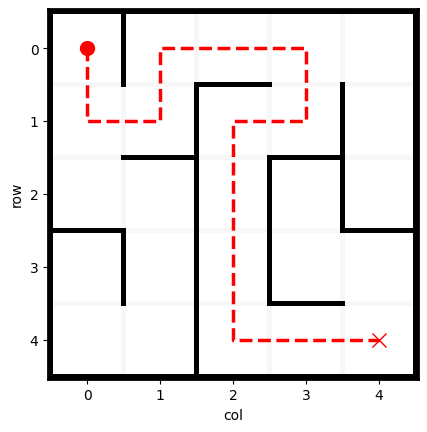

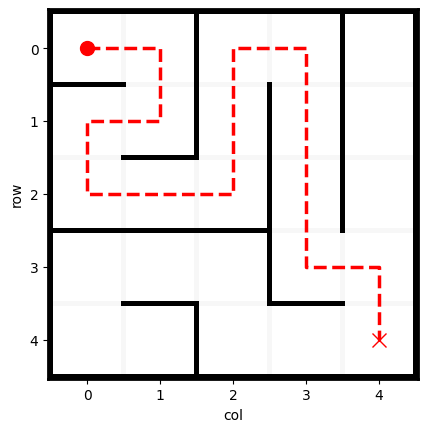

In [108]:
from maze_dataset.plotting import MazePlot
for maze in dataset:
    MazePlot(maze).plot()

# MDP로 변환

In [109]:
from typing import Dict, Tuple
import numpy as np

# MDP를 구성할 때 사용할 액션(상하좌우)
ACTIONS = {
    "UP":    (-1, 0),
    "DOWN":  (1, 0),
    "LEFT":  (0, -1),
    "RIGHT": (0, 1),
}

def create_mdp_from_solved_maze(solved_maze):
    """
    maze_dataset의 SolvedMaze 객체(solved_maze)를 받아,
    각 격자를 상태, 상하좌우 이동을 행동으로 하는 MDP를 구성한다.
    """

    # 미로 크기: 예) (5, 5)
    grid_shape = solved_maze.grid_shape  # (n_row, n_col)
    
    # 도착 지점(목표) 좌표 (예: (grid_n-1, grid_n-1)에 해당)
    # SolvedMaze 내부에 end_pos가 있으므로 그대로 사용 가능
    #   - 만약 None이면, 따로 설정해주거나 임의로 정해야 함
    goal_coord = tuple(solved_maze.end_pos.tolist()) if solved_maze.end_pos is not None else None
    
    # --- MDP 구성요소 ---
    # 1. 상태 공간 (states)
    # 2. 행동 공간 (actions) - 여기서는 상하좌우 4가지
    # 3. 전이함수 transition: T(s,a) -> s'
    # 4. 보상함수 reward: R(s,a,s')
    # ------------------------------------------------

    # 각 상태에서 {행동: (다음 상태, 전이확률, 보상)} 구조를 저장하는 딕셔너리
    # 딕셔너리 구조 예시:
    # mdp[(r,c)] = {
    #   "UP":    [((r-1, c), 1.0, 0.0)],     # 리스트 형태(확률적 MDP 일반화)
    #   "DOWN":  [((r+1, c), 1.0, 0.0)],
    #   "LEFT":  [((r, c-1), 1.0, 0.0)],
    #   "RIGHT": [((r, c+1), 1.0, 0.0)]
    # }
    mdp = {}

    # 모든 격자 좌표(상태)를 순회
    for row in range(grid_shape[0]):
        for col in range(grid_shape[1]):
            current_state = (row, col)
            mdp[current_state] = {}

            # 미로 상의 실제 연결관계를 확인
            # SolvedMaze는 LatticeMaze를 상속하며, get_coord_neighbors() 메서드로
            # 현재 좌표에서 연결된(벽이 없는) 이웃 좌표를 얻을 수 있음.
            neighbors = solved_maze.get_coord_neighbors(
                np.array([row, col], dtype=np.int8)
            )
            # neighbors는 [[r1, c1], [r2, c2], ...] 형태 (ndarray)

            # 4방향 액션 각각 확인
            for action_name, (dr, dc) in ACTIONS.items():
                next_r = row + dr
                next_c = col + dc
                next_state = (next_r, next_c)

                # 기본 값: 이동 불가능(벽이 있거나 범위 밖) → 상태전이 없음
                # 이동 가능한 경우(미로에서 연결되어 있는 경우)에만 추가
                mdp[current_state][action_name] = []

                # 범위를 벗어나지 않고, 실제 미로에서 연결되어 있으면 이동 가능
                if 0 <= next_r < grid_shape[0] and 0 <= next_c < grid_shape[1]:
                    if [next_r, next_c] in neighbors.tolist():
                        # 보상 설계:
                        #  - 예) goal_coord(끝지점) 도달 시 +1, 그 외 0
                        reward = 0.0
                        if goal_coord is not None and (next_r, next_c) == goal_coord:
                            reward = 1.0
                        # 결정적 이동: 전이확률 = 1.0
                        transition_prob = 1.0

                        # MDP에 액션 결과 등록
                        mdp[current_state][action_name].append(
                            (next_state, transition_prob, reward)
                        )
                    else:
                        # 벽이 가로막힌 상태 → 이동 불가능 (transitions 없음)
                        pass
                # else: 범위 바깥 → 이동 불가능

    return mdp

# -----------------------------------------------------------------
# 예시 사용
# -----------------------------------------------------------------
if __name__ == "__main__":
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    # 1) 간단한 DFS 미로 생성
    cfg = MazeDatasetConfig(
        name="mdp_test",
        grid_n=5,
        n_mazes=1,  # 하나만 생성
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        # 예시: 시작 (0,0), 끝 (4,4) 고정
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(4, 4)],
        )
    )

    dataset = MazeDataset.from_config(cfg)
    solved_maze = dataset[0]
    print("ASCII maze:\n", solved_maze.as_ascii(show_endpoints=True))

    # 2) MDP 변환
    mdp_dict = create_mdp_from_solved_maze(solved_maze)

    # 3) 예시로, (0,0) 상태의 가능한 action들을 출력
    print("\nMDP transitions from state (0,0):")
    for action, outcomes in mdp_dict[(0,0)].items():
        # outcomes는 리스트: [(next_state, prob, reward), ...]
        print(f"  Action '{action}' -> {outcomes}")


ASCII maze:
 ###########
#SXXXX  # #
# ###X# # #
#   #X#   #
#####X#####
#XXXXX#   #
#X### ### #
#X#     # #
#X####### #
#XXXXXXXXE#
###########

MDP transitions from state (0,0):
  Action 'UP' -> []
  Action 'DOWN' -> [((1, 0), 1.0, 0.0)]
  Action 'LEFT' -> []
  Action 'RIGHT' -> [((0, 1), 1.0, 0.0)]


c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([0, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([4, 4]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [2, 1],
       [2, 0],
       [3, 0],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(


In [110]:
def print_possible_actions(mdp):
    """
    mdp[state][action] = [(next_state, prob, reward), ...] 형태를 받아
    각 state에서 가능한 action들을 텍스트로 출력.
    """
    for state in sorted(mdp.keys()):
        # 가능한 action = 실제로 next_state가 존재하는 action
        possible_actions = []
        for action, transitions in mdp[state].items():
            if len(transitions) > 0:
                possible_actions.append(action)
        print(f"State {state} => Actions: {possible_actions}")


In [111]:
import networkx as nx

def mdp_to_nx_digraph(mdp):
    """
    MDP 딕셔너리를 NetworkX DiGraph로 변환.
    노드: state (row, col)
    간선: state -> next_state
        - edge 데이터: {'action': action_name, 'prob': transition_prob, 'reward': reward}
    """
    G = nx.DiGraph()
    
    for state, action_dict in mdp.items():
        # 노드 추가
        G.add_node(state)
        for action_name, transitions in action_dict.items():
            for (next_state, prob, reward) in transitions:
                # 확률(prob)이 0 이상인 경우만 실제 간선으로 추가
                if prob > 0:
                    G.add_edge(
                        state,
                        next_state,
                        action=action_name,
                        prob=prob,
                        reward=reward
                    )
    return G


In [112]:
import matplotlib.pyplot as plt

def draw_mdp_graph(G, grid_shape):
    """
    2D 격자로 구성된 MDP를 NetworkX로 시각화.
    - 노드 위치: (col, -row)
    - 에지에 액션 이름(label)을 표시
    """
    # (row, col)을 (x=col, y=-row) 위치로 매핑
    pos = {}
    for r in range(grid_shape[0]):
        for c in range(grid_shape[1]):
            pos[(r,c)] = (c, -r)  # x=c, y=-r
    
    plt.figure(figsize=(8, 6))
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos=pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(G, pos=pos, font_size=10, font_color='black')

    # 에지 그리기 (화살표 표시)
    nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->')

    # 에지 라벨 (action)
    edge_labels = {(u, v): d['action'] 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=8)

    plt.axis("off")
    plt.title("MDP Graph: States and Actions")
    plt.tight_layout()
    plt.show()


State (0, 0) => Actions: ['DOWN', 'RIGHT']
State (0, 1) => Actions: ['LEFT', 'RIGHT']
State (0, 2) => Actions: ['DOWN', 'LEFT', 'RIGHT']
State (0, 3) => Actions: ['DOWN', 'LEFT']
State (0, 4) => Actions: ['DOWN']
State (1, 0) => Actions: ['UP', 'RIGHT']
State (1, 1) => Actions: ['LEFT']
State (1, 2) => Actions: ['UP', 'DOWN']
State (1, 3) => Actions: ['UP', 'RIGHT']
State (1, 4) => Actions: ['UP', 'LEFT']
State (2, 0) => Actions: ['DOWN', 'RIGHT']
State (2, 1) => Actions: ['LEFT', 'RIGHT']
State (2, 2) => Actions: ['UP', 'DOWN', 'LEFT']
State (2, 3) => Actions: ['RIGHT']
State (2, 4) => Actions: ['DOWN', 'LEFT']
State (3, 0) => Actions: ['UP', 'DOWN']
State (3, 1) => Actions: ['RIGHT']
State (3, 2) => Actions: ['UP', 'LEFT', 'RIGHT']
State (3, 3) => Actions: ['LEFT']
State (3, 4) => Actions: ['UP', 'DOWN']
State (4, 0) => Actions: ['UP', 'RIGHT']
State (4, 1) => Actions: ['LEFT', 'RIGHT']
State (4, 2) => Actions: ['LEFT', 'RIGHT']
State (4, 3) => Actions: ['LEFT', 'RIGHT']
State (4, 4)

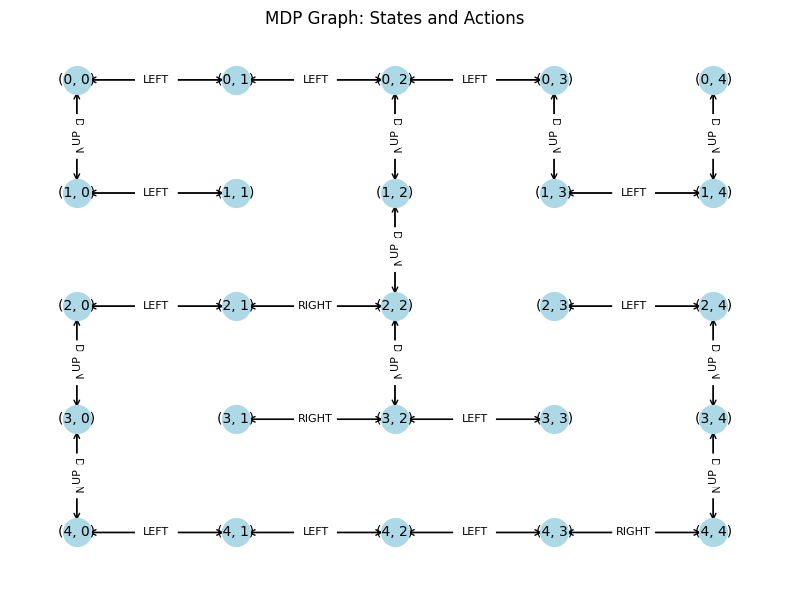

In [113]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    # 1) 작은 미로 생성 (ex: 3x3)
    cfg = MazeDatasetConfig(
        name="mdp_graph_example",
        grid_n=5,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(4, 4)],
        )
    )
    dataset = MazeDataset.from_config(cfg)
    solved_maze = dataset[0]

    # 2) MDP 구성
    mdp = create_mdp_from_solved_maze(solved_maze)
    
    # 텍스트 형태로 가능한 액션 출력
    print_possible_actions(mdp)

    # 3) NetworkX로 그래프 구성 및 시각화
    G = mdp_to_nx_digraph(mdp)
    draw_mdp_graph(G, grid_shape=solved_maze.grid_shape)


In [130]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_mdp_graph_arcs(G, grid_shape):
    """
    2D 격자 DiGraph(G)에 대해:
      - (row, col)을 (x=col, y=-row)로 매핑
      - 양방향 간선이 있으면 서로 다른 곡률(rad)로 화살표를 그림
    """
    # 노드 위치 계산
    pos = {(r, c): (c, -r) for r in range(grid_shape[0]) for c in range(grid_shape[1])}

    # 노드 그리기
    plt.figure(figsize=(30, 30))
    nx.draw_networkx_nodes(G, pos=pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(G, pos=pos, font_size=10, font_color='black')

    # 모든 간선을 모아서, "단방향" vs. "양방향"을 구분
    edges_done = set()
    edges_uni = []   # (u, v)만 있고 (v, u)는 없는 경우
    edges_bi_fwd = []  # (u, v)와 (v, u)가 함께 있는 경우 중 (u, v)
    edges_bi_bwd = []  # (u, v)와 (v, u)가 함께 있는 경우 중 (v, u)

    for (u, v) in G.edges():
        if (v, u) in G.edges():
            # 양방향인 경우
            if (v, u) not in edges_done:
                # (u,v), (v,u) 둘 다 아직 안 처리 -> forward/backward 분리
                edges_bi_fwd.append((u, v))
                edges_bi_bwd.append((v, u))
                edges_done.add((u, v))
                edges_done.add((v, u))
        else:
            # 단방향
            edges_uni.append((u, v))
            edges_done.add((u, v))

    # 1) 단방향(edge) 먼저 그림 (곡률 없음)
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=edges_uni,
        arrowstyle='->',
        arrows=True,
        connectionstyle='arc3,rad=0.0',  # 직선
        edge_color='black'
    )

    # 2) 양방향 중 (u->v) 부분
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=edges_bi_fwd,
        arrowstyle='->',
        arrows=True,
        connectionstyle='arc3,rad=0.2',  # +0.2 곡률
        edge_color='blue'
    )
    #    반대방향 (v->u)
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=edges_bi_bwd,
        arrowstyle='->',
        arrows=True,
        connectionstyle='arc3,rad=-0.2',  # -0.2 곡률
        edge_color='red'
    )

    # 에지 라벨 달기
    #   draw_networkx_edge_labels는 "에지 리스트"별로 분할해서 그릴 수 있음
    #   or 한 번에 그리되 label_pos 등으로 약간 조정
    edge_labels = {}
    for (u, v, data) in G.edges(data=True):
        action_name = data.get('action', '')
        edge_labels[(u, v)] = action_name

    # 단방향 라벨
    nx.draw_networkx_edge_labels(
        G, pos=pos,
        edge_labels={e: edge_labels[e] for e in edges_uni},
        font_size=8, label_pos=0.3
    )
    # 양방향 forward 라벨
    nx.draw_networkx_edge_labels(
        G, pos=pos,
        edge_labels={e: edge_labels[e] for e in edges_bi_fwd},
        font_color='blue', font_size=8,
        label_pos=0.3
    )
    # 양방향 backward 라벨
    nx.draw_networkx_edge_labels(
        G, pos=pos,
        edge_labels={e: edge_labels[e] for e in edges_bi_bwd},
        font_color='red', font_size=8,
        label_pos=0.3
    )

    plt.axis('off')
    plt.title("MDP Graph with arcs (directed edges)")
    plt.tight_layout()
    plt.show()


State (0, 0) => Actions: ['DOWN', 'RIGHT']
State (0, 1) => Actions: ['LEFT', 'RIGHT']
State (0, 2) => Actions: ['DOWN', 'LEFT', 'RIGHT']
State (0, 3) => Actions: ['DOWN', 'LEFT']
State (0, 4) => Actions: ['DOWN']
State (1, 0) => Actions: ['UP', 'RIGHT']
State (1, 1) => Actions: ['LEFT']
State (1, 2) => Actions: ['UP', 'DOWN']
State (1, 3) => Actions: ['UP', 'RIGHT']
State (1, 4) => Actions: ['UP', 'LEFT']
State (2, 0) => Actions: ['DOWN', 'RIGHT']
State (2, 1) => Actions: ['LEFT', 'RIGHT']
State (2, 2) => Actions: ['UP', 'DOWN', 'LEFT']
State (2, 3) => Actions: ['RIGHT']
State (2, 4) => Actions: ['DOWN', 'LEFT']
State (3, 0) => Actions: ['UP', 'DOWN']
State (3, 1) => Actions: ['RIGHT']
State (3, 2) => Actions: ['UP', 'LEFT', 'RIGHT']
State (3, 3) => Actions: ['LEFT']
State (3, 4) => Actions: ['UP', 'DOWN']
State (4, 0) => Actions: ['UP', 'RIGHT']
State (4, 1) => Actions: ['LEFT', 'RIGHT']
State (4, 2) => Actions: ['LEFT', 'RIGHT']
State (4, 3) => Actions: ['LEFT', 'RIGHT']
State (4, 4)

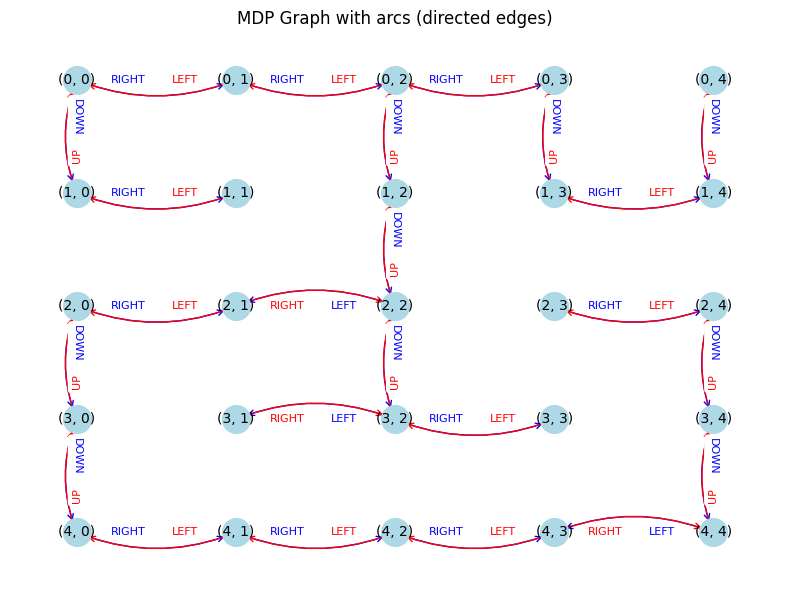

In [115]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    # 1) 작은 미로 생성 (ex: 3x3)
    cfg = MazeDatasetConfig(
        name="mdp_graph_example",
        grid_n=5,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(4, 4)],
        )
    )
    dataset = MazeDataset.from_config(cfg)
    solved_maze = dataset[0]

    # 2) MDP 구성
    mdp = create_mdp_from_solved_maze(solved_maze)
    
    # 텍스트 형태로 가능한 액션 출력
    print_possible_actions(mdp)

    # 3) NetworkX로 그래프 구성 및 시각화
    G = mdp_to_nx_digraph(mdp)
    draw_mdp_graph_arcs(G, grid_shape=solved_maze.grid_shape)


# 큰 미로와 작은 미로 사이의 공통부분 찾기

In [116]:
import numpy as np
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators

def generate_small_maze_3x3() -> "LatticeMaze":
    """
    3×3 미로를 하나 생성해 반환.
    여기서는 DFS 알고리즘 + do_forks=True 예시.
    """
    cfg = MazeDatasetConfig(
        name="small_3x3",
        grid_n=3,              # 3×3
        n_mazes=1,            # 하나만 생성
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
    )
    dataset = MazeDataset.from_config(cfg)
    # dataset[0]은 SolvedMaze 객체이나, SolvedMaze는 LatticeMaze(부모)에 연결 정보가 들어 있음
    small_maze = dataset[0]
    return small_maze

def generate_big_mazes_10x10(num_mazes=10) -> list:
    """
    10×10 미로를 num_mazes(기본 10개) 생성해 리스트로 반환.
    """
    cfg = MazeDatasetConfig(
        name="big_10x10",
        grid_n=10,             # 10×10
        n_mazes=num_mazes,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
    )
    dataset = MazeDataset.from_config(cfg)
    # SolvedMaze 객체들을 리스트로 반환
    big_mazes = [dataset[i] for i in range(len(dataset))]
    return big_mazes

def has_submaze_pattern(small_maze, big_maze) -> bool:
    """
    big_maze 내부에 small_maze(3×3)의 벽 배치 패턴이 정확히 일치하는 부분이 있는지 확인.
    일치하면 True, 아니면 False를 반환.
    
    - small_maze.connection_list.shape == (2, 3, 3)
    - big_maze.connection_list.shape == (2, 10, 10)
    
    슬라이싱으로 big_maze의 (2, 3×3) 부분이 small_maze.connection_list와 같은지 검사.
    """
    small_conn = small_maze.connection_list  # shape = (2, 3, 3)
    big_conn = big_maze.connection_list      # shape = (2, 10, 10)
    
    # 10×10에서 3×3을 슬라이스하려면, row/col 시작 인덱스가 [0..(10-3)] = [0..7]
    for r in range(10 - 3 + 1):
        for c in range(10 - 3 + 1):
            # big_conn[:, r:r+3, c:c+3]와 small_conn[:]이 동일한지 비교
            sub_block = big_conn[:, r:r+3, c:c+3]
            
            if np.array_equal(sub_block, small_conn):
                return True  # 하나라도 매칭되면 True 리턴
    
    return False

def main():
    # 1) 3×3 미로 생성
    small_maze = generate_small_maze_3x3()
    print("=== Small Maze (3×3) ===")
    print(small_maze.as_ascii(show_endpoints=True))
    
    # 2) 10×10 미로 10개 생성
    big_mazes = generate_big_mazes_10x10(num_mazes=10)
    
    # 3) 각 10×10 미로에 3×3 패턴이 있는지 검사
    for i, maze in enumerate(big_mazes):
        found = has_submaze_pattern(small_maze, maze)
        print(f"[Big Maze {i}] 동일 패턴 존재 여부: {found}")
        if found:
            # 패턴 매칭된 경우, 미로를 ASCII로 출력해볼 수도 있음
            print(maze.as_ascii(show_endpoints=True))
            print("=> 3×3 패턴이 이 미로 내 일부와 일치합니다.\n")

if __name__ == "__main__":
    main()


=== Small Maze (3×3) ===
#######
#E# # #
#X# # #
#X#  S#
#X###X#
#XXXXX#
#######
[Big Maze 0] 동일 패턴 존재 여부: False
[Big Maze 1] 동일 패턴 존재 여부: False
[Big Maze 2] 동일 패턴 존재 여부: False
[Big Maze 3] 동일 패턴 존재 여부: False
[Big Maze 4] 동일 패턴 존재 여부: False
[Big Maze 5] 동일 패턴 존재 여부: False
[Big Maze 6] 동일 패턴 존재 여부: False
[Big Maze 7] 동일 패턴 존재 여부: False
[Big Maze 8] 동일 패턴 존재 여부: False
[Big Maze 9] 동일 패턴 존재 여부: False


c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([1, 2]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([0, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[1, 2],
       [2, 2],
       [2, 1],
       [2, 0],
       [1, 0],
       [0, 0]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(
c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:

#강제로 동일 패턴 만들기

=== small_maze (3×3) ===
#######
#E# # #
#X# # #
#X#  S#
#X###X#
#XXXXX#
#######

=== big_maze (10×10 including 3×3 pattern) ===
#####################
#S# # # #     #     #
#X# # # # ### # # ###
#X#   #   # # # #   #
#X### ##### # # ### #
#XXXXX#       #   # #
#####X# ######### # #
#  XXX# #         # #
# #X# # # ######### #
# #X# # # #         #
###X# # # # ####### #
#XXX# # # #       # #
#X##### ######### ###
#X#     #XXXXXXX#   #
#X# #####X#####X### #
#X#   #XXX#    XXXXX#
#X### #X###########X#
#X  # #XXXXXXX#XXXXX#
#X### #######X#X#####
#XXXXXXXXXXXXX#XXXXE#
#####################


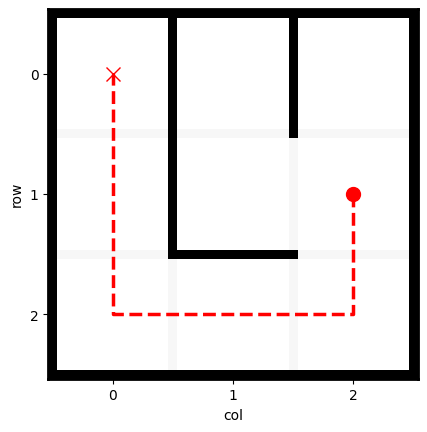

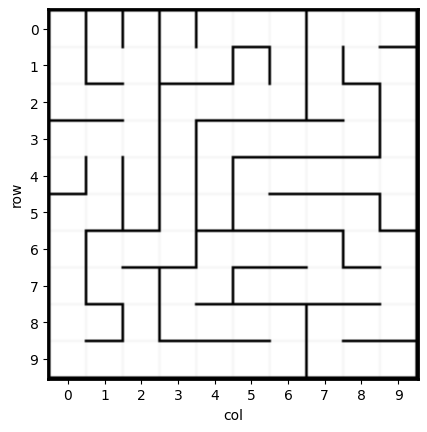

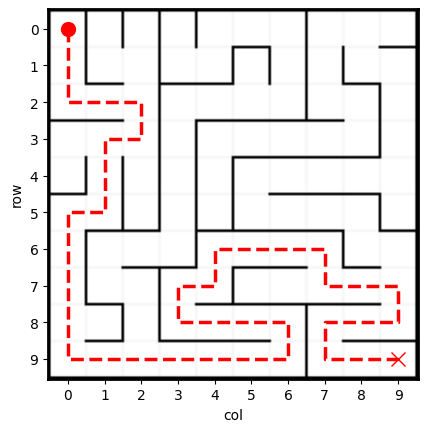

In [117]:
import numpy as np

from maze_dataset import LatticeMaze, MazeDataset, MazeDatasetConfig, SolvedMaze
from maze_dataset.generation import LatticeMazeGenerators

def generate_small_maze_3x3() -> LatticeMaze:
    """
    3×3 미로를 하나 생성해 반환 (DFS)
    """
    cfg = MazeDatasetConfig(
        name="small_3x3",
        grid_n=3,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        
    )
    dataset = MazeDataset.from_config(cfg)
    # dataset[0]은 SolvedMaze 타입 -> 내부에 LatticeMaze 구조를 가짐
    small_maze = dataset[0]
    return small_maze

def create_empty_connection_list_10x10() -> np.ndarray:
    """
    shape = (2, 10, 10) 짜리 bool 배열을 전부 False로 초기화.
    index 0: down 연결, index 1: right 연결
    """
    # maze-dataset은 (lattice_dim=2, row=10, col=10)을 기본으로 사용
    # 관례적으로: [0,:,:] -> 수직방향(Down), [1,:,:] -> 수평방향(Right)
    return np.zeros((2, 10, 10), dtype=bool)

def embed_3x3_into_10x10(
    big_conn: np.ndarray,
    small_conn: np.ndarray,
    top_left=(0,0)
):
    """
    big_conn(10x10) 내부에 small_conn(3x3)을 강제로 삽입.
    - top_left=(r,c)부터 (r+2, c+2) 범위에 해당 3x3 패턴 복사
    """
    (r0, c0) = top_left
    r1, c1 = r0+3, c0+3  # slice 끝 위치
    # small_conn.shape == (2, 3, 3)
    big_conn[:, r0:r1, c0:c1] = small_conn

def fill_rest_with_dfs(big_conn: np.ndarray, skip_region, seed=42):
    """
    - skip_region: (r0, c0, r1, c1) 튜플로, [r0:r1, c0:c1] 영역은 건드리지 않음.
    - 나머지 영역을 DFS 기반으로 랜덤 연결(간단 시연).
    - 실제 maze-dataset의 gen_dfs 코드를 이용해도 되지만,
      여기선 '이미 부분이 채워진 big_conn'을 덮어쓰지 않도록
      간단한 custom 코드를 작성합니다.
    """
    import random
    random.seed(seed)

    # 편의상 row-major 방식으로 무작위 순회
    rows, cols = big_conn.shape[1], big_conn.shape[2]  # (10,10)
    r0, c0, r1, c1 = skip_region  # 예: (0,0,3,3)
    
    visited = np.zeros((rows, cols), dtype=bool)
    # 이미 skip_region은 "3x3 패턴 확정"이라 가정하고 visited=True로 표시
    visited[r0:r1, c0:c1] = True

    def neighbors(r, c):
        """4방향 이웃 좌표"""
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                yield nr, nc

    # DFS
    stack = []
    
    # 전체 grid에서 skip_region 아닌 아무 한 점을 시작점으로 선택
    for rr in range(rows):
        for cc in range(cols):
            if not (r0 <= rr < r1 and c0 <= cc < c1):
                stack.append((rr,cc))
                visited[rr,cc] = True
                break
        if stack:
            break
    
    while stack:
        cr, cc = stack.pop()
        # 이웃 중 방문 안 한 것 추출
        unvisited_neighbors = [(nr, nc) for (nr, nc) in neighbors(cr, cc) 
                               if not visited[nr, nc]]
        if unvisited_neighbors:
            # 스택에 다시 (cr, cc) 넣기 (DFS 알고리즘)
            stack.append((cr,cc))
            # 임의의 이웃 하나 선택
            nr, nc = random.choice(unvisited_neighbors)
            # 연결(true) 표시
            if nr == cr+1 and nc == cc:
                # down 방향
                big_conn[0, cr, cc] = True  # [0,:,:] -> down
            elif nr == cr-1 and nc == cc:
                # up 방향 = down 방향 반대
                big_conn[0, nr, nc] = True
            elif nr == cr and nc == cc+1:
                # right 방향
                big_conn[1, cr, cc] = True
            elif nr == cr and nc == cc-1:
                # left 방향 = right 방향 반대
                big_conn[1, nr, nc] = True
            
            # 방문 체크
            visited[nr, nc] = True
            stack.append((nr,nc))

def ensure_connect_boundary(big_conn: np.ndarray, top_left=(0,0)):
    """
    3x3 블록과 나머지 영역 간에 하나 이상 연결이 있도록
    3x3 블록 테두리를 무작위로 골라 벽을 열어줄 수도 있음.
    
    - 여기서는 간단히 '오른쪽/아래 테두리'를 무조건 연결해버리는 시연 예시
    """
    r0, c0 = top_left
    # 3x3 블록의 우측 테두리: column = c0+2
    # 아래 테두리: row = r0+2
    # 3x3 이하 범위가 0~2이므로, (2, x) or (x, 2)에 대해 한두 군데 벽을 열어줄 수 있음
    
    # 예) (2,2) ~ (2,3) or (2,2) ~ (3,2) 연결
    # 여기서는 (2,2) 아래로 열어버리자
    r_down = r0 + 2
    c_down = c0 + 2
    if r_down+1 < 10:
        big_conn[0, r_down, c_down] = True  # down
    # (2,2)에서 오른쪽 연결도 열고 싶다면:
    # if c_down+1 < 10:
    #     big_conn[1, r_down, c_down] = True  # right

def create_10x10_including_3x3(small_maze: LatticeMaze, seed=42) -> LatticeMaze:
    """
    1) 10x10 false로 초기화
    2) small_maze(3x3) 패턴을 (0,0)~(2,2)에 삽입
    3) 나머지 영역(3~9, 0~9 / 0~9, 3~9 등)을 DFS로 채움
    4) 3x3과 나머지 영역 경계에 연결부위 생성
    5) LatticeMaze 객체로 만들기
    """
    big_conn = create_empty_connection_list_10x10()        # (2,10,10)
    small_conn = small_maze.connection_list                # (2,3,3)
    
    # 2) 3×3 패턴 삽입
    embed_3x3_into_10x10(big_conn, small_conn, top_left=(0,0))
    
    # 3) DFS로 나머지 영역 채우기
    skip_region = (0, 0, 3, 3)   # row0=0..2, col0=0..2
    fill_rest_with_dfs(big_conn, skip_region, seed=seed)
    
    # 4) 경계 연결 (간단 예시)
    ensure_connect_boundary(big_conn, top_left=(0,0))
    
    # 5) LatticeMaze 만들기
    big_maze = LatticeMaze(
        connection_list=big_conn,
        generation_meta={"description": "10x10 containing 3x3 subpattern"},
    )
    return big_maze

# -----------------------------
# 전체 시연
# -----------------------------
if __name__ == "__main__":
    # 1) 3x3 미로 확보
    small_maze = generate_small_maze_3x3()
    print("=== small_maze (3×3) ===")
    print(small_maze.as_ascii(show_endpoints=True))

    # 2) 10x10에 3×3 패턴을 '강제 내장'한 커스텀 미로 생성
    big_maze = create_10x10_including_3x3(small_maze, seed=123)
    
    # 3) LatticeMaze -> SolvedMaze 변환 (start, end 아무렇게나)
    #    혹은 그냥 as_ascii() 가능
    #    SolvedMaze로 만들려면, 임의의 start & end 경로를 잡는다.
    from maze_dataset.maze.lattice_maze import LatticeMaze
    from maze_dataset.maze.lattice_maze import SolvedMaze

    # 간단히 (0,0)->(9,9)로 path
    path_ = big_maze.find_shortest_path((0,0), (9,9))  # A*기반
    big_solved = SolvedMaze.from_lattice_maze(
        lattice_maze=big_maze,
        solution=[tuple(x) for x in path_.tolist()],
    )

    # 4) ASCII 출력
    print("\n=== big_maze (10×10 including 3×3 pattern) ===")
    print(big_solved.as_ascii(show_endpoints=True, show_solution=True))
    MazePlot(small_maze).plot()
    MazePlot(big_maze).plot()
    MazePlot(big_solved).plot()


In [118]:
def generate_small_maze_3x3() -> LatticeMaze:
    """
    3×3 미로를 하나 생성해 반환 (DFS).
    시작점은 (0,0), 종료점은 (2,2)로 고정.
    """
    from maze_dataset import MazeDataset, MazeDatasetConfig
    from maze_dataset.generation import LatticeMazeGenerators

    cfg = MazeDatasetConfig(
        name="small_3x3",
        grid_n=3,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(2, 2)],
        )
    )
    dataset = MazeDataset.from_config(cfg)
    # dataset[0]은 SolvedMaze 타입 -> 내부에 LatticeMaze 구조 + solution
    small_solved = dataset[0]  # type: SolvedMaze

    # 여기서 small_solved.start_pos => [0,0], small_solved.end_pos => [2,2]
    return small_solved


In [119]:
# 간단히 (0,0)->(9,9)로 path
path_ = big_maze.find_shortest_path((0,0), (9,9))  # A*기반
big_solved = SolvedMaze.from_lattice_maze(
    lattice_maze=big_maze,
    solution=[tuple(x) for x in path_.tolist()],
)


=== small_maze (3×3) ===
#######
#S# # #
#X# # #
#X#   #
#X### #
#XXXXE#
#######

=== big_maze (10×10) ===
#####################
#S# # # #     #     #
#X# # # # ### # # ###
#X#   #   # # # #   #
#X### ##### # # ### #
#XXXXX#       #   # #
#####X# ######### # #
#  XXX# #         # #
# #X# # # ######### #
# #X# # # #         #
###X# # # # ####### #
#XXX# # # #       # #
#X##### ######### ###
#X#     #XXXXXXX#   #
#X# #####X#####X### #
#X#   #XXX#    XXXXX#
#X### #X###########X#
#X  # #XXXXXXX#XXXXX#
#X### #######X#X#####
#XXXXXXXXXXXXX#XXXXE#
#####################


c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([0, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([2, 2]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[0, 0],
       [1, 0],
       [2, 0],
       [2, 1],
       [2, 2]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(


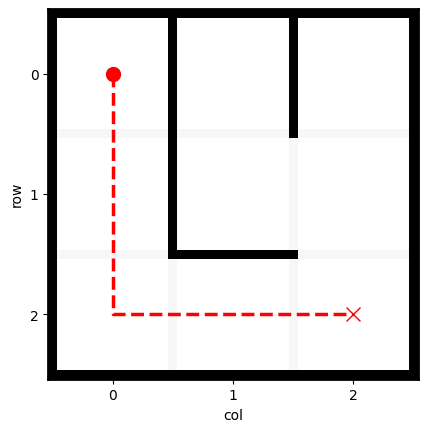

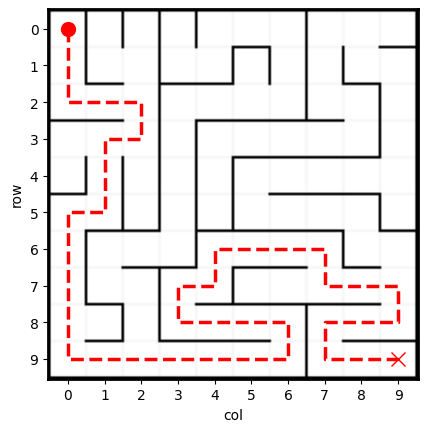

In [120]:
import numpy as np
from maze_dataset import LatticeMaze, MazeDataset, MazeDatasetConfig, SolvedMaze
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.plotting import MazePlot

def generate_small_maze_3x3() -> SolvedMaze:
    """
    3×3 미로를 하나 생성해 반환 (DFS)
    시작점 (0,0), 종료점 (2,2) 고정
    """
    cfg = MazeDatasetConfig(
        name="small_3x3",
        grid_n=3,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0,0)],
            allowed_end=[(2,2)],
        ),
    )
    dataset = MazeDataset.from_config(cfg)
    small_solved = dataset[0]
    return small_solved

def create_10x10_including_3x3(small_maze: LatticeMaze, seed=42) -> LatticeMaze:
    """
    커스텀 로직:
      1) 10x10 false로 초기화
      2) small_maze(3x3) 패턴을 (0,0)~(2,2)에 삽입
      3) 나머지 영역(3~9, 0~9 / 0~9, 3~9 등)을 DFS로 채움
      4) 3x3과 나머지 영역 경계에 연결부위 생성
      5) LatticeMaze 객체로 만들기
    """
    big_conn = create_empty_connection_list_10x10()        # (2,10,10)
    small_conn = small_maze.connection_list                # (2,3,3)
    
    embed_3x3_into_10x10(big_conn, small_conn, top_left=(0,0))

    skip_region = (0, 0, 3, 3)
    fill_rest_with_dfs(big_conn, skip_region, seed=seed)
    
    ensure_connect_boundary(big_conn, top_left=(0,0))
    
    big_maze = LatticeMaze(
        connection_list=big_conn,
        generation_meta={"description": "10x10 containing 3x3 subpattern"},
    )
    return big_maze

if __name__ == "__main__":
    # 1) 3×3 미로 (start=(0,0), end=(2,2)) 생성
    small_solved = generate_small_maze_3x3()
    print("=== small_maze (3×3) ===")
    print(small_solved.as_ascii(show_endpoints=True, show_solution=True))

    # 2) 10×10에 3×3 패턴 삽입
    big_maze = create_10x10_including_3x3(small_solved, seed=123)

    # 3) 10×10 미로 => SolvedMaze 변환 (start=(0,0), end=(9,9))
    path_ = big_maze.find_shortest_path((0,0), (9,9))
    big_solved = SolvedMaze.from_lattice_maze(
        lattice_maze=big_maze,
        solution=[tuple(x) for x in path_.tolist()],
    )

    # 4) ASCII 출력 => S가 (0,0), E가 (9,9)
    print("\n=== big_maze (10×10) ===")
    print(big_solved.as_ascii(show_endpoints=True, show_solution=True))

    # 시각화
    MazePlot(small_solved).plot()
    MazePlot(big_solved).plot()


# iteration


=== [Small Maze #0] ===
#######
#S# # #
#X# # #
#X#   #
#X### #
#XXXXE#
#######
--- Big Maze 0 (10×10) from Small Maze #0 ---
#####################
#S# # # #   #       #
#X# # # # # ####### #
#X#   #   #         #
#X### ############# #
#XXXXX#     #       #
#####X# ### # #######
#    X# # #   #     #
#####X# # ##### ### #
#XXXXX# #       #   #
#X### # ### ##### ###
#X  # #     #     # #
#X# ######### ##### #
#X#         # #  XXX#
#X####### ### ###X#X#
#X#XXXXX#     #XXX#X#
#X#X###X#######X###X#
#X#X#XXX#    XXX# #X#
#X#X#X#######X### #X#
#XXX#XXXXXXXXX#    E#
#####################
--- Big Maze 1 (10×10) from Small Maze #0 ---
#####################
#S# # # #           #
#X# # # ######### # #
#X#   # #       # # #
#X### # # ##### ### #
#XXXXX#   #   #     #
#####X####### ##### #
#    XXX      # #   #
# #####X##### # # ###
#   #XXX#   #   #   #
# ###X### ##### ### #
# #XXX#     #   #   #
# #X### ### # ### ###
# #XXX#   #   # # # #
# ###X####### # # # #
#   #XXXXXXX#   # # #
### #######X#

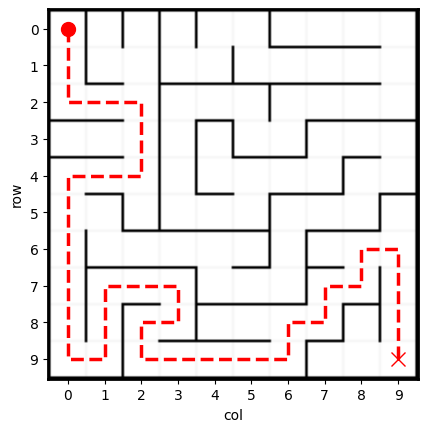

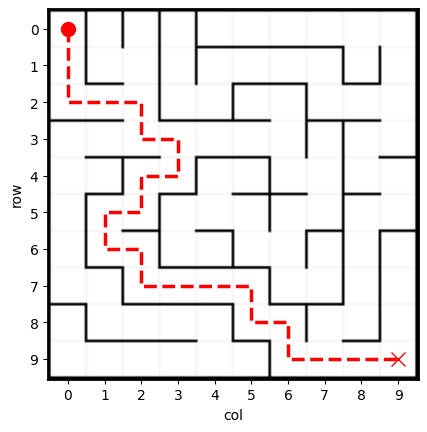

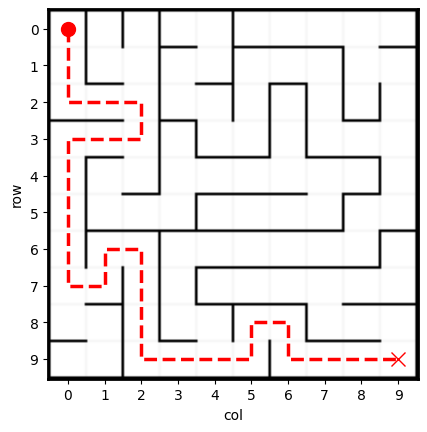

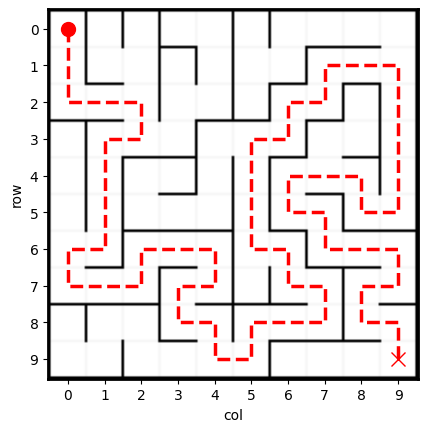

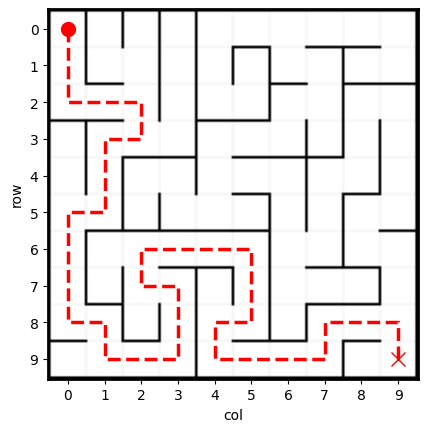

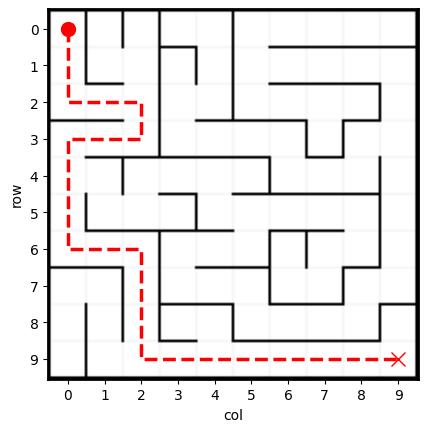

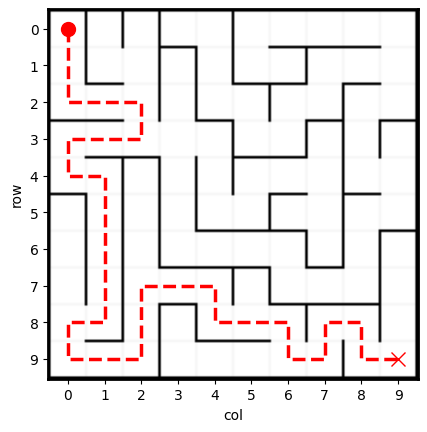

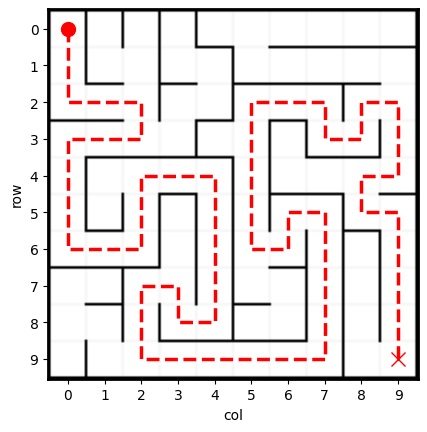

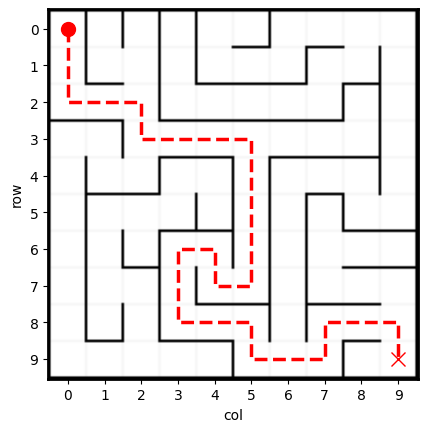

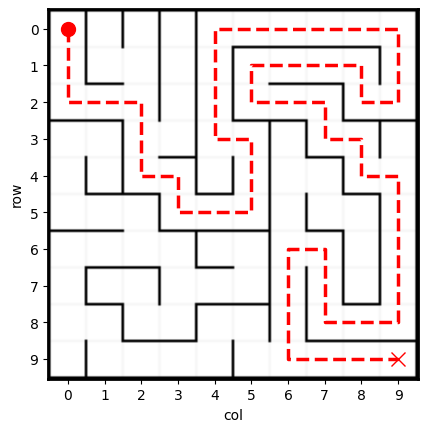

In [124]:
import numpy as np
import random
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.maze.lattice_maze import LatticeMaze, SolvedMaze
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.plotting import MazePlot

def generate_small_3x3_mazes(n_small=3, seed=42):
    """
    n_small개의 3×3 미로 생성, 각각 시작점=(0,0), 종료점=(2,2) 고정.
    returns: list of SolvedMaze
    """
    cfg = MazeDatasetConfig(
        name="small_3x3_multiple",
        grid_n=3,
        n_mazes=n_small,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(2, 2)],
        ),
        seed=seed  # 시드 고정(또는 None을 통해 무작위)
    )
    dataset = MazeDataset.from_config(cfg)
    # 이 데이터셋은 n_small개의 SolvedMaze를 포함
    small_mazes = [dataset[i] for i in range(len(dataset))]
    return small_mazes

def create_empty_connection_list_10x10() -> np.ndarray:
    return np.zeros((2, 10, 10), dtype=bool)

def embed_3x3_into_10x10(
    big_conn: np.ndarray,
    small_conn: np.ndarray,
    top_left=(0,0)
):
    (r0, c0) = top_left
    r1, c1 = r0+3, c0+3
    big_conn[:, r0:r1, c0:c1] = small_conn

def fill_rest_with_dfs(big_conn: np.ndarray, skip_region, seed=42):
    import random
    random.seed(seed)

    rows, cols = big_conn.shape[1], big_conn.shape[2]
    (r0, c0, r1, c1) = skip_region
    
    visited = np.zeros((rows, cols), dtype=bool)
    visited[r0:r1, c0:c1] = True

    def neighbors(r, c):
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                yield nr, nc

    stack = []
    # skip_region이 아닌 첫 좌표를 찾아 시작점으로
    for rr in range(rows):
        for cc in range(cols):
            if not (r0 <= rr < r1 and c0 <= cc < c1):
                stack.append((rr,cc))
                visited[rr,cc] = True
                break
        if stack:
            break
    
    while stack:
        cr, cc = stack.pop()
        unvisited_neighbors = [(nr, nc) for (nr, nc) in neighbors(cr, cc)
                               if not visited[nr, nc]]
        if unvisited_neighbors:
            stack.append((cr, cc))
            nr, nc = random.choice(unvisited_neighbors)
            # 벽 열기
            if nr == cr+1 and nc == cc:
                big_conn[0, cr, cc] = True
            elif nr == cr-1 and nc == cc:
                big_conn[0, nr, nc] = True
            elif nr == cr and nc == cc+1:
                big_conn[1, cr, cc] = True
            elif nr == cr and nc == cc-1:
                big_conn[1, nr, nc] = True
            visited[nr, nc] = True
            stack.append((nr, nc))

def ensure_connect_boundary(big_conn: np.ndarray, top_left=(0,0)):
    # 3×3 블록의 (2,2) 아래쪽 벽을 열어 연결
    r0, c0 = top_left
    r_down, c_down = r0 + 2, c0 + 2
    if r_down+1 < 10:
        big_conn[0, r_down, c_down] = True

def create_10x10_including_3x3(
    small_maze: LatticeMaze, 
    seed=123,
    embed_pos=(0,0),
) -> LatticeMaze:
    """
    주어진 small_maze(3×3) 패턴을 10×10에 삽입 + 나머지 영역 DFS 채움
    """
    big_conn = create_empty_connection_list_10x10()
    small_conn = small_maze.connection_list
    embed_3x3_into_10x10(big_conn, small_conn, top_left=embed_pos)

    r0, c0 = embed_pos
    skip_region = (r0, c0, r0+3, c0+3)
    fill_rest_with_dfs(big_conn, skip_region, seed=seed)

    ensure_connect_boundary(big_conn, top_left=embed_pos)

    big_maze = LatticeMaze(
        connection_list=big_conn,
        generation_meta={"desc": "10x10 with 3x3 subpattern"},
    )
    return big_maze

def generate_multiple_big_mazes(
    small_maze: LatticeMaze,
    n_big=5,
    seed=100
) -> list[SolvedMaze]:
    """
    small_maze(3×3) 하나를 받아서,
    n_big개의 10×10 미로를 생성.
    각 미로에 대해 (0,0)->(9,9) path를 구해 SolvedMaze로 반환.
    """
    big_solved_list = []
    rng = random.Random(seed)
    for i in range(n_big):
        # 임의 시드
        new_seed = rng.randint(0, 10_000_000)
        # (0,0)에 삽입 (원한다면 랜덤 위치 embed_pos도 가능)
        big_maze = create_10x10_including_3x3(small_maze, seed=new_seed, embed_pos=(0,0))
        # start=(0,0), end=(9,9)로 경로
        path_ = big_maze.find_shortest_path((0,0), (9,9))
        big_solved = SolvedMaze.from_lattice_maze(
            lattice_maze=big_maze,
            solution=[tuple(x) for x in path_.tolist()],
        )
        big_solved_list.append(big_solved)
    return big_solved_list

# -----------------------------
# 메인
# -----------------------------
if __name__ == "__main__":
    # 1) 여러 개의 3×3 미로 생성
    small_mazes = generate_small_3x3_mazes(n_small=1, seed=42)
    # small_mazes: 예) [SolvedMaze(3x3 #0), SolvedMaze(3x3 #1), ...]

    for idx_s, sm in enumerate(small_mazes):
        print(f"\n=== [Small Maze #{idx_s}] ===")
        print(sm.as_ascii(show_endpoints=True, show_solution=True))
        
        # 2) 각 3×3 미로를 포함하는 10×10 미로를 여러 개 생성
        big_solved_list = generate_multiple_big_mazes(sm, n_big=10, seed=100)

        for idx_b, big_solved in enumerate(big_solved_list):
            print(f"--- Big Maze {idx_b} (10×10) from Small Maze #{idx_s} ---")
            print(big_solved.as_ascii(show_endpoints=True, show_solution=True))
            MazePlot(big_solved).plot()


# 작은 maze를 포함하는 부분을 Randomize

[Small Maze 3×3]
#######
#S# # #
#X# # #
#X#   #
#X### #
#XXXXE#
#######

[Big Maze 10×10 with random-embedded 3×3]
  => embedded top_left = (2,7)
#####################
#S#      XXX#   #   #
#X#######X#X# # ### #
#XXX#XXXXX#XXX#     #
###X#X#######X#######
# #X#XXX#XXX#X# # # #
# #X###X#X#X#X# # # #
# #XXX#XXX#X#X# #   #
# ###X### #X#X# ### #
#   #XXX# #X#X#     #
### ###X# #X#X##### #
#   #XXX# #X#XXXXXXX#
# # #X#####X#######X#
# # #XXX#XXX#     #X#
# #####X#X### ### #X#
#     #X#XXX# #   #X#
# ### #X###X# #####X#
# #   #XXX#X# #XXXXX#
# # #####X#X# #X#####
# #      XXX#  XXXXE#
#####################


c:\Users\sean2\anaconda3\envs\mdp\Lib\site-packages\muutils\json_serialize\serializable_dataclass.py:878: UserWarning: Type mismatch in fields of SolvedMaze:
start_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([0, 0]), type(getattr(output, k)) = <class 'numpy.ndarray'>
end_pos:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'row_col']'>, but got value getattr(output, k) = array([2, 2]), type(getattr(output, k)) = <class 'numpy.ndarray'>
solution:	expected cls_type_hints[k] = <class 'jaxtyping.Int8[ndarray, 'coord row_col']'>, but got value getattr(output, k) = array([[0, 0],
       [1, 0],
       [2, 0],
       [2, 1],
       [2, 2]]), type(getattr(output, k)) = <class 'numpy.ndarray'>
  on_typecheck_mismatch.process(


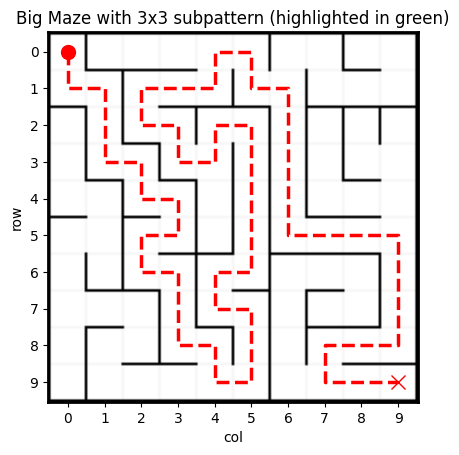

State (0, 0) => Actions: ['DOWN']
State (0, 1) => Actions: ['RIGHT']
State (0, 2) => Actions: ['LEFT', 'RIGHT']
State (0, 3) => Actions: ['LEFT', 'RIGHT']
State (0, 4) => Actions: ['DOWN', 'LEFT', 'RIGHT']
State (0, 5) => Actions: ['DOWN', 'LEFT']
State (0, 6) => Actions: ['DOWN', 'RIGHT']
State (0, 7) => Actions: ['DOWN', 'LEFT']
State (0, 8) => Actions: ['RIGHT']
State (0, 9) => Actions: ['DOWN', 'LEFT']
State (1, 0) => Actions: ['UP', 'RIGHT']
State (1, 1) => Actions: ['DOWN', 'LEFT']
State (1, 2) => Actions: ['DOWN', 'RIGHT']
State (1, 3) => Actions: ['LEFT', 'RIGHT']
State (1, 4) => Actions: ['UP', 'LEFT']
State (1, 5) => Actions: ['UP', 'RIGHT']
State (1, 6) => Actions: ['UP', 'DOWN', 'LEFT']
State (1, 7) => Actions: ['UP', 'RIGHT']
State (1, 8) => Actions: ['LEFT', 'RIGHT']
State (1, 9) => Actions: ['UP', 'LEFT']
State (2, 0) => Actions: ['DOWN']
State (2, 1) => Actions: ['UP', 'DOWN']
State (2, 2) => Actions: ['UP', 'RIGHT']
State (2, 3) => Actions: ['DOWN', 'LEFT']
State (2, 4

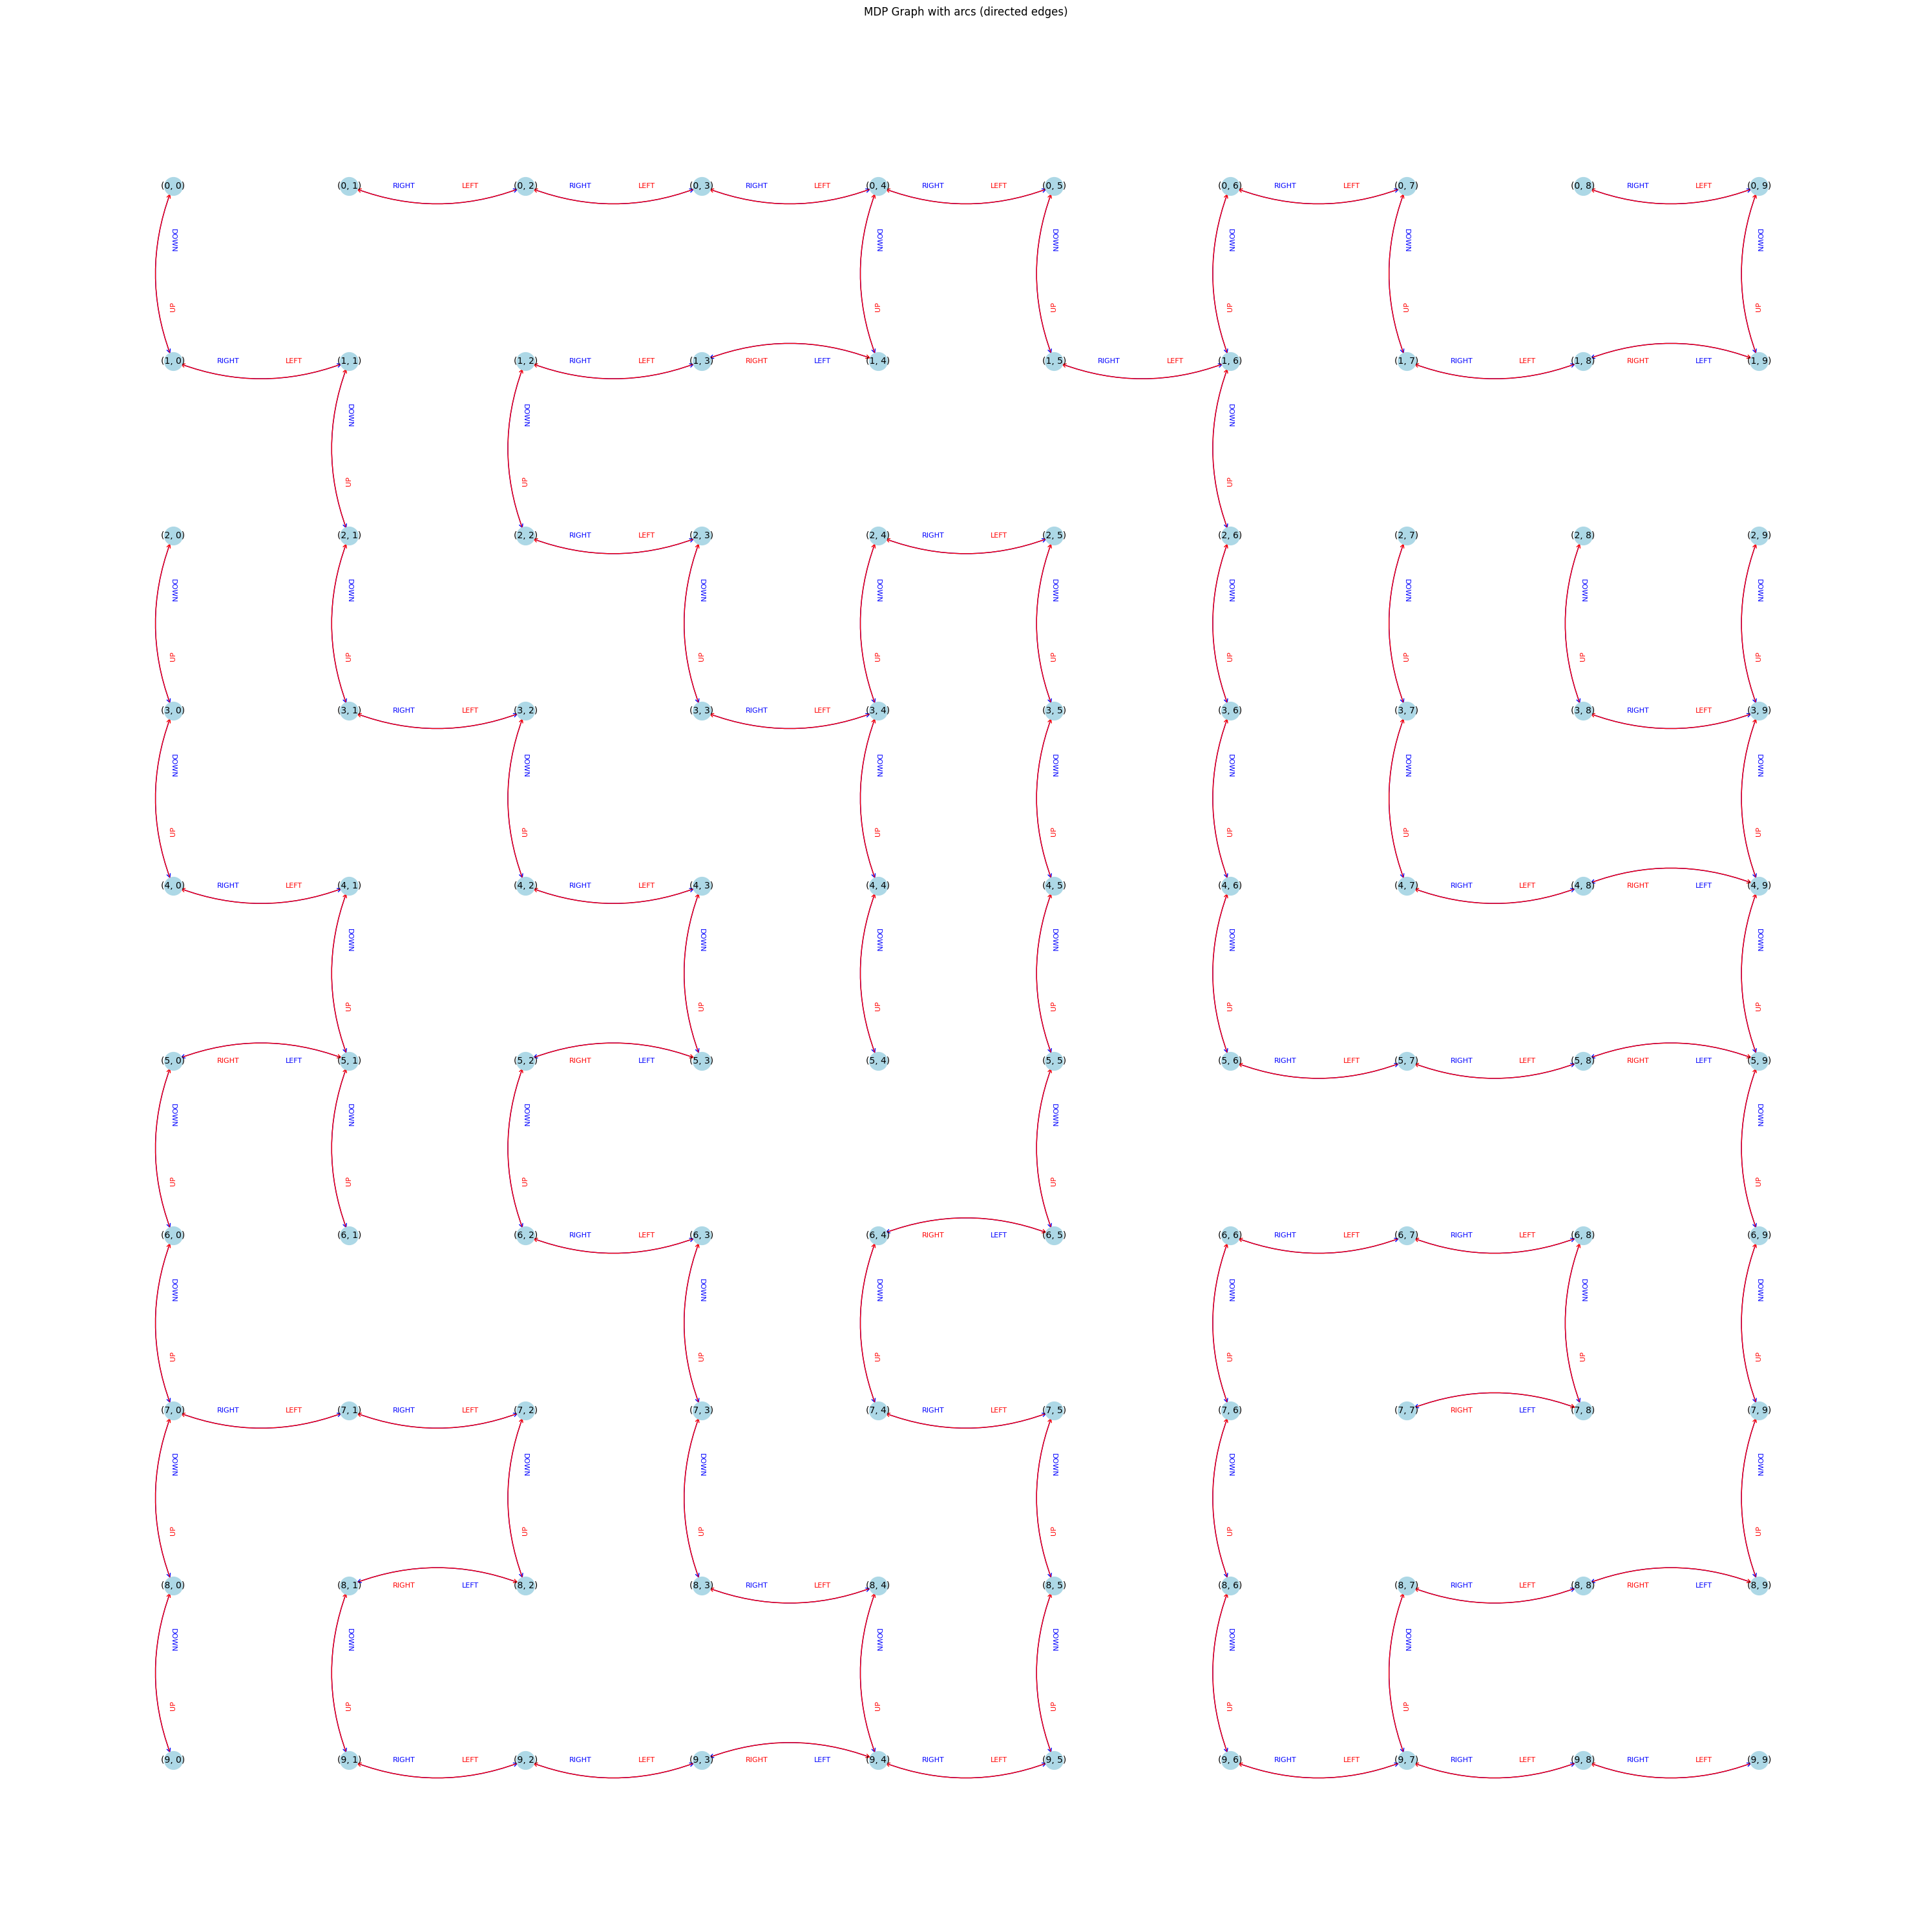

State (0, 0) => Actions: ['DOWN']
State (0, 1) => Actions: ['DOWN']
State (0, 2) => Actions: ['DOWN']
State (1, 0) => Actions: ['UP', 'DOWN']
State (1, 1) => Actions: ['UP', 'RIGHT']
State (1, 2) => Actions: ['UP', 'DOWN', 'LEFT']
State (2, 0) => Actions: ['UP', 'RIGHT']
State (2, 1) => Actions: ['LEFT', 'RIGHT']
State (2, 2) => Actions: ['UP', 'LEFT']


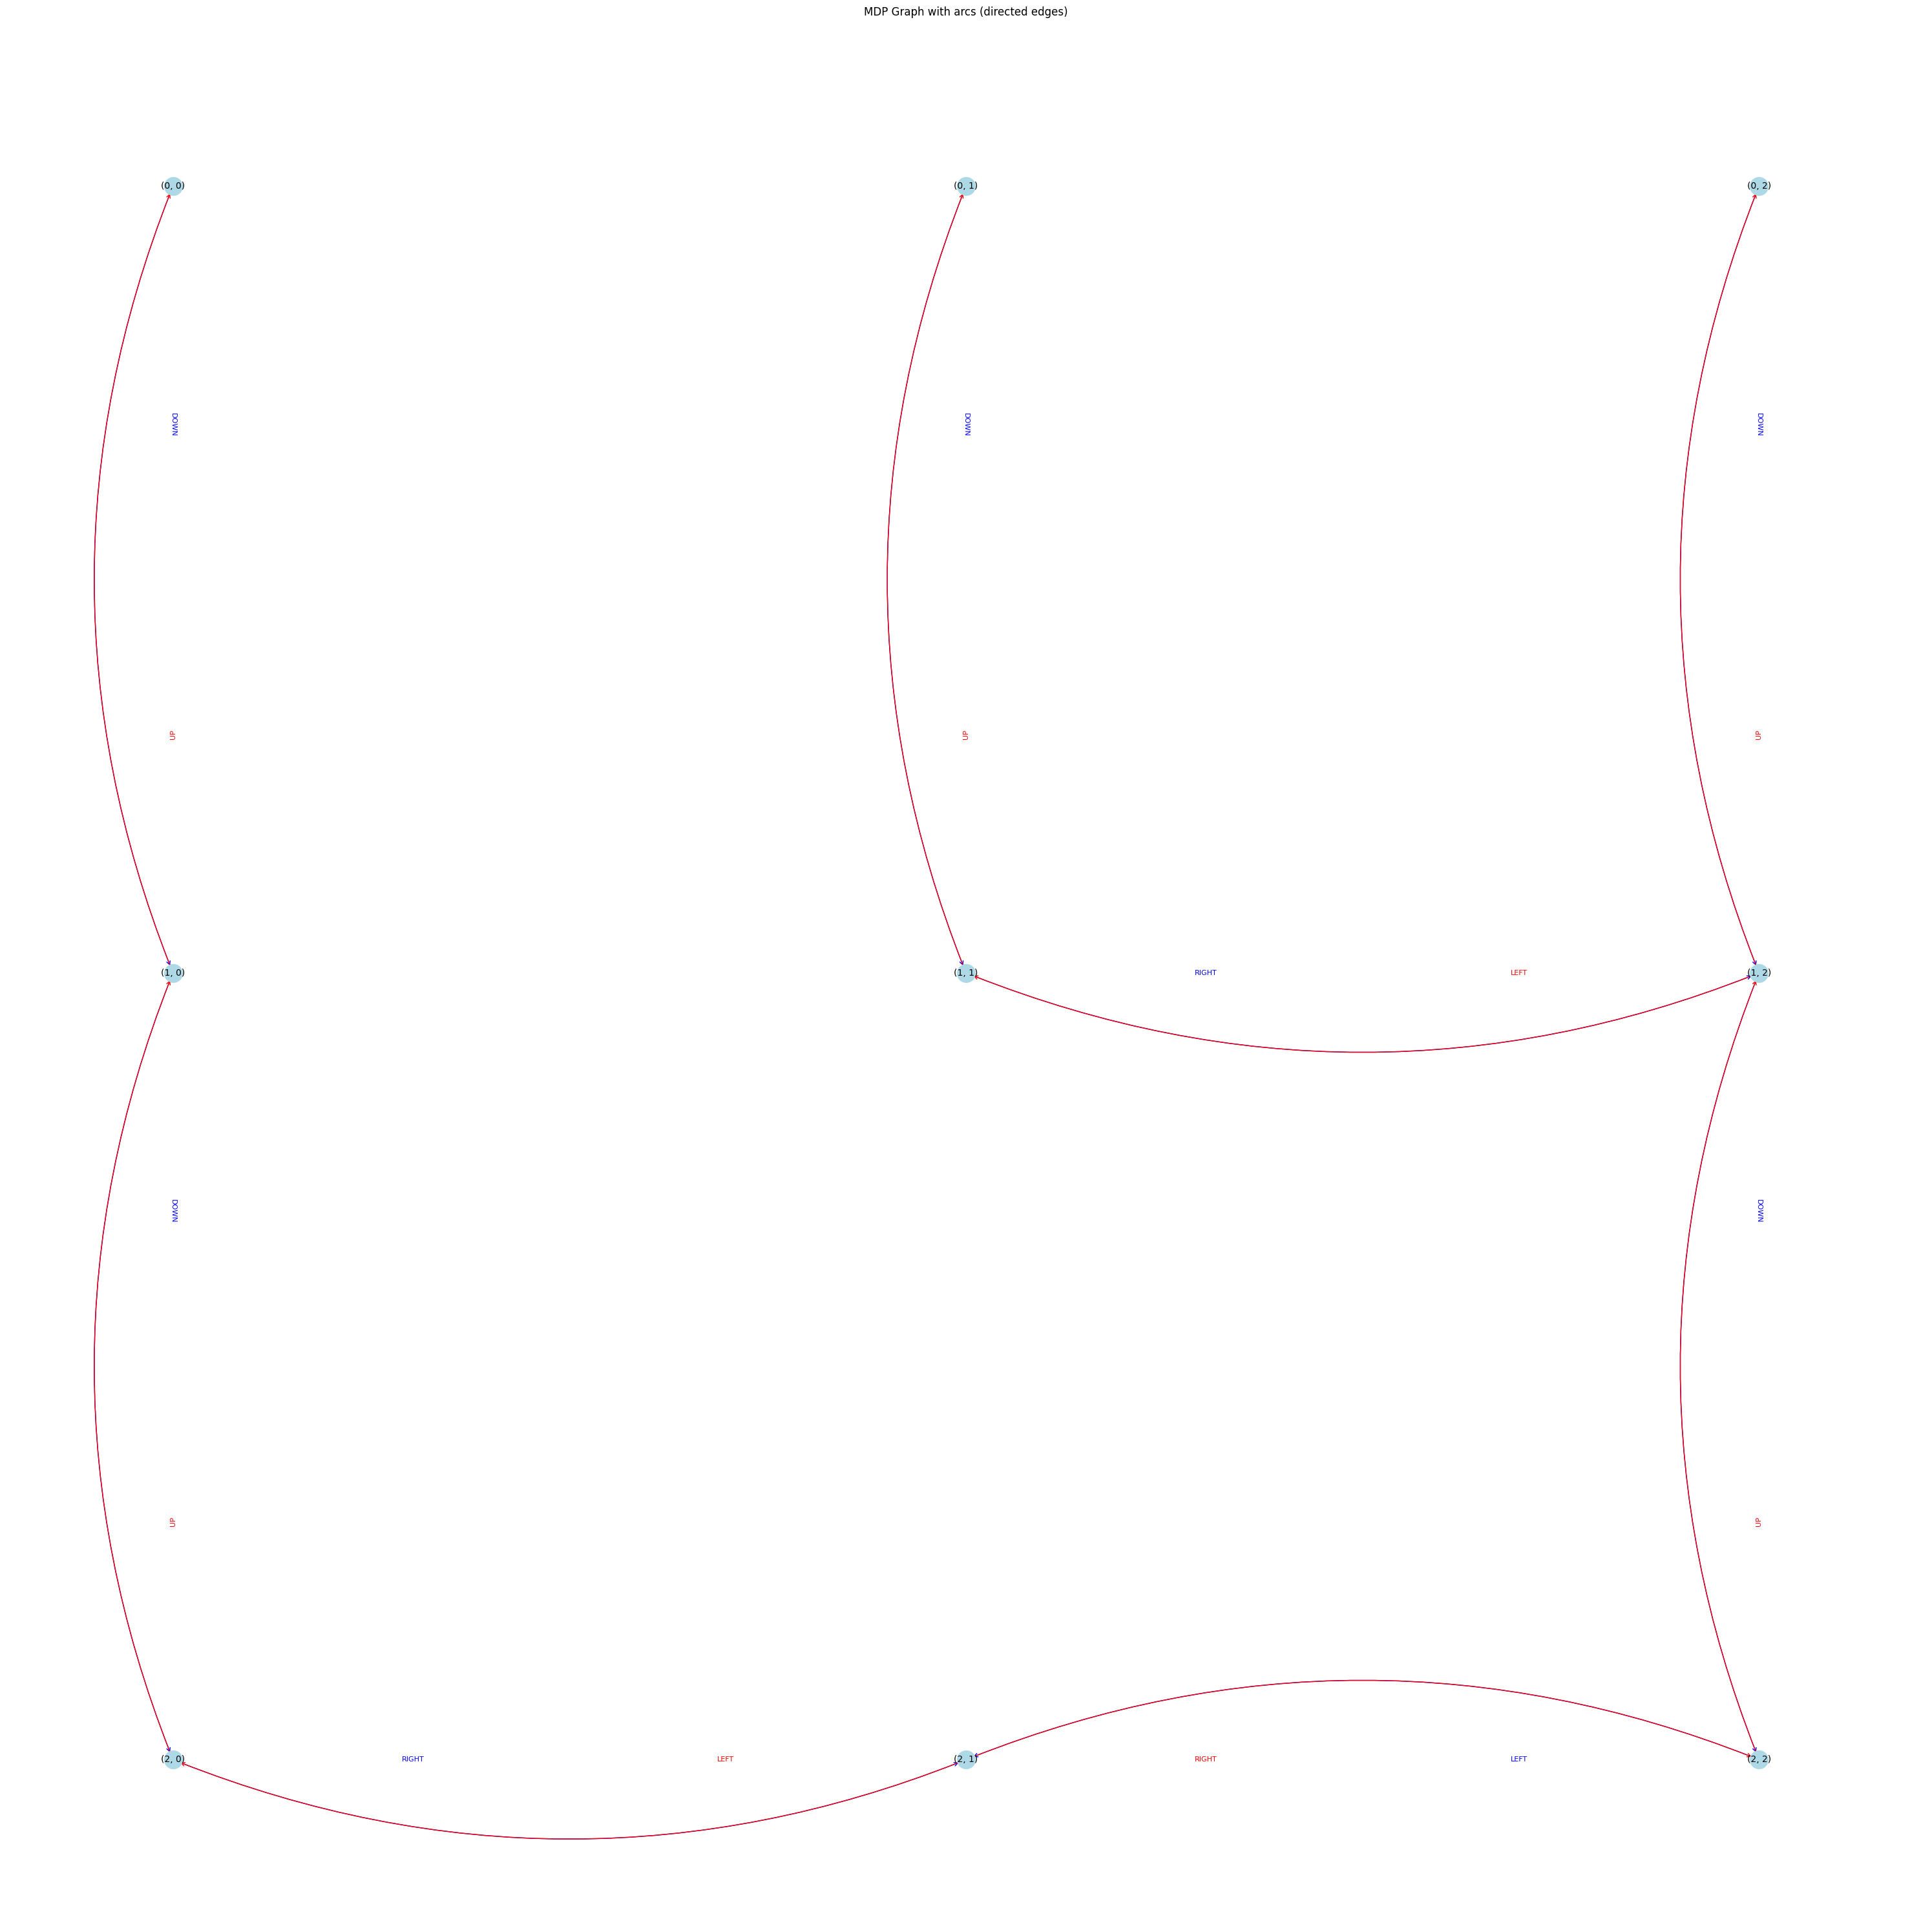

In [132]:
import numpy as np
import random
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.maze.lattice_maze import LatticeMaze, SolvedMaze
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.plotting import MazePlot
import matplotlib.pyplot as plt

def generate_small_maze_3x3(seed=42) -> LatticeMaze:
    """
    3×3 미로 하나를 생성해 반환 (DFS).
    임의로 시작/끝점 고정: (0,0) ~ (2,2) 
    """
    cfg = MazeDatasetConfig(
        name="small_3x3",
        grid_n=3,
        n_mazes=1,
        maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(do_forks=True),
        endpoint_kwargs=dict(
            allowed_start=[(0, 0)],
            allowed_end=[(2, 2)],
        ),
        seed=seed
    )
    dataset = MazeDataset.from_config(cfg)
    small_solved = dataset[0]
    # small_solved은 SolvedMaze지만, .connection_list로 LatticeMaze 정보 참조 가능
    return small_solved

def create_empty_connection_list_10x10() -> np.ndarray:
    """
    (2, 10, 10) shape의 bool 배열을 False로 초기화
    index=0: 세로(Down), index=1: 가로(Right)
    """
    return np.zeros((2, 10, 10), dtype=bool)

def embed_3x3_into_10x10(big_conn: np.ndarray, small_conn: np.ndarray, top_left=(0,0)):
    """
    big_conn(10x10) 내부에 small_conn(3x3) 패턴 삽입
    - top_left=(r,c)부터 (r+2, c+2) 부분에 복사
    """
    (r0, c0) = top_left
    r1, c1 = r0 + 3, c0 + 3
    big_conn[:, r0:r1, c0:c1] = small_conn

def fill_rest_with_dfs(big_conn: np.ndarray, skip_region, seed=42):
    """
    skip_region: (r0, c0, r1, c1)
      - 이 영역은 건드리지 않고, 나머지 칸들을 DFS로 임의 연결
    """
    import random
    random.seed(seed)

    rows, cols = big_conn.shape[1], big_conn.shape[2]  # 10x10
    (r0, c0, r1, c1) = skip_region
    
    visited = np.zeros((rows, cols), dtype=bool)
    visited[r0:r1, c0:c1] = True

    def neighbors(r, c):
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols:
                yield nr, nc

    stack = []
    # skip_region이 아닌 임의 위치를 찾아 방문 시작
    for rr in range(rows):
        for cc in range(cols):
            if not (r0 <= rr < r1 and c0 <= cc < c1):
                stack.append((rr,cc))
                visited[rr,cc] = True
                break
        if stack:
            break
    
    while stack:
        cr, cc = stack.pop()
        unvisited_neighbors = [(nr, nc) for (nr, nc) in neighbors(cr, cc) 
                               if not visited[nr, nc]]
        if unvisited_neighbors:
            stack.append((cr, cc))
            nr, nc = random.choice(unvisited_neighbors)
            # 연결 true로 설정
            if nr == cr+1 and nc == cc:
                big_conn[0, cr, cc] = True  # Down
            elif nr == cr-1 and nc == cc:
                big_conn[0, nr, nc] = True  # Up
            elif nr == cr and nc == cc+1:
                big_conn[1, cr, cc] = True  # Right
            elif nr == cr and nc == cc-1:
                big_conn[1, nr, nc] = True  # Left
            visited[nr, nc] = True
            stack.append((nr, nc))

def ensure_connect_boundary(big_conn: np.ndarray, top_left=(0,0)):
    """
    3×3 블록과 나머지 영역을 '적어도 한 곳'은 연결
    여기서는 (2,2) 아래 방향을 열어 둠 (단순 예시)
    """
    r0, c0 = top_left
    rr, cc = r0+2, c0+2
    if rr+1 < 10:
        big_conn[0, rr, cc] = True  # Down

def create_10x10_including_3x3_random(
    small_maze: LatticeMaze,
    seed=123
) -> (LatticeMaze, tuple):
    """
    1) 무작위 top_left = (r0, c0)를 [0..7, 0..7]에서 뽑아
    2) 10x10 연결 구조 big_conn 초기화
    3) small_maze(3x3) 패턴을 그 위치에 삽입
    4) 나머지 DFS로 채우고, 경계 연결
    5) LatticeMaze 생성하여 반환 + 3×3이 들어간 좌표 영역( (r0,c0)~(r0+2,c0+2) )도 반환
    """
    rng = random.Random(seed)
    r0 = rng.randint(0, 7)
    c0 = rng.randint(0, 7)
    big_conn = create_empty_connection_list_10x10()
    small_conn = small_maze.connection_list

    embed_3x3_into_10x10(big_conn, small_conn, top_left=(r0, c0))

    skip_region = (r0, c0, r0+3, c0+3)
    fill_rest_with_dfs(big_conn, skip_region, seed=seed)
    
    ensure_connect_boundary(big_conn, top_left=(r0, c0))

    big_maze = LatticeMaze(
        connection_list=big_conn,
        generation_meta={"desc": "10x10 with 3x3 subpattern at random position"},
    )
    return big_maze, (r0, c0)

# -----------------------------
# 메인
# -----------------------------
if __name__ == "__main__":
    # 1) 작은 미로(3×3) 생성
    small_solved = generate_small_maze_3x3(seed=42)
    print("[Small Maze 3×3]")
    print(small_solved.as_ascii(show_endpoints=True, show_solution=True))

    # 2) 큰 미로(10×10)에 3×3을 "랜덤 위치"에 삽입
    #    => 예: seed=100
    big_maze, (r0, c0) = create_10x10_including_3x3_random(small_solved, seed=100)
    
    # 3) 시작=(0,0), 종료=(9,9)로 경로를 찾아서 SolvedMaze 생성
    path_ = big_maze.find_shortest_path((0,0), (9,9))
    big_solved = SolvedMaze.from_lattice_maze(
        lattice_maze=big_maze,
        solution=[tuple(x) for x in path_.tolist()],
    )

    # 4) ASCII 출력
    print("\n[Big Maze 10×10 with random-embedded 3×3]")
    print(f"  => embedded top_left = ({r0},{c0})")
    print(big_solved.as_ascii(show_endpoints=True, show_solution=True))

    # 5) MazePlot으로 시각화 + 3×3 영역을 초록색 하이라이트
    #    3×3 영역의 모든 (row,col)을 highlight_nodes에 추가
    highlight_cells = [(rr, cc) for rr in range(r0, r0+3) for cc in range(c0, c0+3)]
    mp = MazePlot(
        big_solved,
        # highlight_nodes=highlight_cells,
        # highlight_color="green"  # 초록색
    )
    mp.plot()
    plt.title("Big Maze with 3x3 subpattern (highlighted in green)")
    plt.show()
        # 2) MDP 구성
    mdp = create_mdp_from_solved_maze(big_solved)
    
    # 텍스트 형태로 가능한 액션 출력
    print_possible_actions(mdp)

    # 3) NetworkX로 그래프 구성 및 시각화
    G = mdp_to_nx_digraph(mdp)
    draw_mdp_graph_arcs(G, grid_shape=big_solved.grid_shape)
    mdp2 = create_mdp_from_solved_maze(small_solved)
    
    # 텍스트 형태로 가능한 액션 출력
    print_possible_actions(mdp2)

    # 3) NetworkX로 그래프 구성 및 시각화
    G = mdp_to_nx_digraph(mdp2)
    draw_mdp_graph_arcs(G, grid_shape=small_solved.grid_shape)